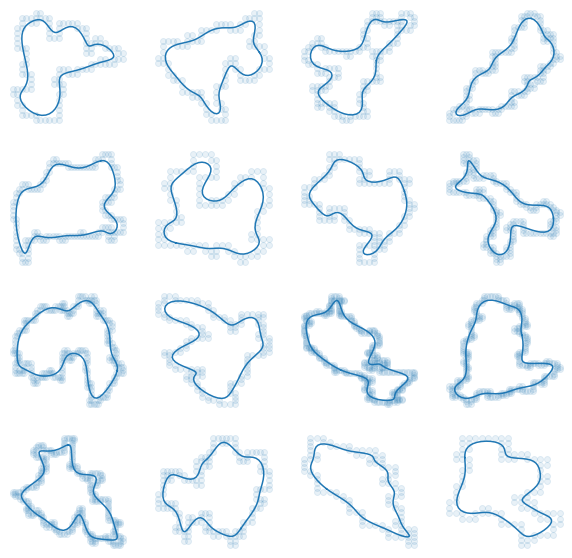

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def remove_axes(ax):
    """
    Remove axes from plot.
    """
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    return None

    
def loop_erased_rw(min_loop_size, n_fourier_modes, regul_strength, smoothness):
    """
    Does a loop-erased random walk and waits for a sufficiently big loop,
    Then fits a Fourier Series to it.
    
    inputs
    =====
    min_loop_size: minimum allowed loop size.
    n_fourier_modes: number of fourier modes used. If K is given as input, 
                     the function uses frequencies -K, -K+1, .... , 0, 1, ...., K-1, K.
    regul_strength: Strength of tikhonov type regularisation on fourier fit
    smoothness: decay in fourier coefficients in the regularisation
    
    Outputs
    =====
    two tuples,
    func, rw.
    
    func is a tuple (f, c, k) containing a lambda-function f:[0,2pi] -> R^2, fourier coefficients c and frequencies k.
    rw is a tuple (x,y) containing coordinates of the random walk.
    """
    N = 100
    Nmax = min_loop_size

    x,y = [0],[0]
    steps = [(0,1),(0,-1),(-1,0),(1,0)]


    for n in range(100000):
        step_idx = np.random.randint(0,4)
        dx,dy = steps[step_idx]
        xn = x[-1]+dx
        yn = y[-1]+dy

        intersects = [i for i in range(len(y)-1) if x[i]==xn and y[i]==yn]
        assert len(intersects) <= 1, "Something is wrong"

        if len(intersects) == 0:
            x.append(xn)
            y.append(yn)

        elif len(intersects) == 1:
            i = intersects[0]
            if (len(x) - i) >= Nmax:
                x = x[i:]
                y = y[i:]
                break
            else:
                x = x[:i+1]
                y = y[:i+1]        


    # Define numpy arrays
    x = np.array(x)
    y = np.array(y)
    # Center
    x = 2*(x-(min(x)+max(x))/2)/(max(x)-min(x))
    y = 2*(y-(min(y)+max(y))/2)/(max(y)-min(y))
    t = np.linspace(0,2*np.pi,len(x))
    #X,Y
    K = n_fourier_modes
    ks = np.arange(-K, K+1)

    E = np.exp(1j * ks[None, :] * t[:, None])
    Et = np.conjugate(E.T)
    
    A = Et @ E + regul_strength*np.diag((np.abs(ks)+1)**smoothness)
    c = np.linalg.solve(A, Et @ np.hstack([x[:,None], y[:,None]]))
    
    f = lambda t: np.real(np.exp(1j * ks[None, :] * t[:, None]) @ c)
    
    return (f, ks, c), (x, y)



min_loop_size = 100
num_fourier_modes = 10
regularisation = 1.5
smoothness = 2.0

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    func, rw = loop_erased_rw(min_loop_size, \
                              num_fourier_modes,\
                              regularisation,\
                              smoothness)
    xy = func[0](np.linspace(0,2*np.pi, 100))
    
    plt.scatter(rw[0],rw[1], alpha=0.1)
    plt.plot(xy[:,0], xy[:,1])
    remove_axes(plt.gca())